In [ ]:
!pip install kaggle --quiet
!rm -rf ~/.kaggle


In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"keshavguptta05","key":"c6b48e4904a2fe681e460dcb466331f8"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Test
!ls ~/.kaggle


kaggle.json


In [ ]:
!kaggle datasets list -s face


ref                                           title                                  size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------  -------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
andrewmvd/face-mask-detection                 Face Mask Detection               416968083  2020-05-22 07:18:42.220000         106033       1921  0.875            
splcher/animefacedataset                      Anime Face Dataset                413825766  2019-10-13 16:33:20.520000          45393        465  0.9375           
mksaad/wider-face-a-face-detection-benchmark  WIDER FACE                       3662993623  2019-01-05 14:07:49.930000           5120         79  0.4375           
ashwingupta3012/human-faces                   Human Faces                      1952358379  2020-09-21 04:09:12.927000          39211        289  0.875            
andrewmvd/animal-faces

In [ ]:
!kaggle datasets download -d xhlulu/140k-real-and-fake-faces -p /content


Dataset URL: https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces
License(s): other
100% 3.73G/3.75G [01:06<00:01, 15.1MB/s]
100% 3.75G/3.75G [01:06<00:00, 60.1MB/s]


In [ ]:
!unzip -q /content/140k-real-and-fake-faces.zip -d /content/data


In [ ]:
!ls -R /content


Streaming output truncated to the last 5000 lines.
07763.jpg  17708.jpg  27843.jpg  37875.jpg  47853.jpg  57943.jpg  67878.jpg
07764.jpg  17710.jpg  27844.jpg  37876.jpg  47854.jpg  57944.jpg  67880.jpg
07765.jpg  17713.jpg  27845.jpg  37878.jpg  47855.jpg  57946.jpg  67882.jpg
07767.jpg  17714.jpg  27846.jpg  37879.jpg  47856.jpg  57947.jpg  67883.jpg
07769.jpg  17715.jpg  27848.jpg  37880.jpg  47857.jpg  57949.jpg  67885.jpg
07771.jpg  17717.jpg  27849.jpg  37881.jpg  47858.jpg  57950.jpg  67886.jpg
07772.jpg  17720.jpg  27850.jpg  37882.jpg  47859.jpg  57952.jpg  67887.jpg
07774.jpg  17721.jpg  27851.jpg  37883.jpg  47860.jpg  57953.jpg  67888.jpg
07775.jpg  17722.jpg  27852.jpg  37886.jpg  47861.jpg  57955.jpg  67889.jpg
07776.jpg  17723.jpg  27855.jpg  37887.jpg  47864.jpg  57956.jpg  67890.jpg
07777.jpg  17724.jpg  27857.jpg  37889.jpg  47865.jpg  57957.jpg  67891.jpg
07778.jpg  17726.jpg  27858.jpg  37890.jpg  47868.jpg  57958.jpg  67892.jpg
07779.jpg  17727.jpg  27862.jpg  3789

In [ ]:
import os

for root, dirs, files in os.walk("/content"):
    if any(f.endswith(".jpg") for f in files):
        print("FOUND IMAGES IN:", root)
        break


FOUND IMAGES IN: /content/data/real_vs_fake/real-vs-fake/valid/fake


In [ ]:
REAL_DIR = "/content/data/real_vs_fake/real-vs-fake/train/real"
FAKE_DIR = "/content/data/real_vs_fake/real-vs-fake/train/fake"

import os
print("Real images:", len(os.listdir(REAL_DIR)))
print("Fake images:", len(os.listdir(FAKE_DIR)))


Real images: 50000
Fake images: 50000


In [ ]:
import cv2
import numpy as np
from PIL import Image

# Noise Residual (High-pass filter)
def get_noise_residual(img_pil):
    img = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
    blur = cv2.bilateralFilter(img, 7, 50, 50)
    res = cv2.subtract(img, blur)
    res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
    return res

# DCT Frequency Map
def get_dct_map(img_pil, out_size=224):
    gray = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2GRAY)
    gray = cv2.resize(gray, (out_size, out_size))
    dct = cv2.dct(np.float32(gray))
    dct = np.log(np.abs(dct) + 1e-5)
    dct = cv2.normalize(dct, None, 0, 255, cv2.NORM_MINMAX)
    dct = dct.astype(np.uint8)
    return np.stack([dct, dct, dct], axis=-1)


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import random

class DeepfakeDataset(Dataset):
    def __init__(self, real_dir, fake_dir, limit=2000):
        self.samples = []
        real_files = sorted(os.listdir(real_dir))[:limit]
        fake_files = sorted(os.listdir(fake_dir))[:limit]

        for f in real_files:
            self.samples.append((os.path.join(real_dir, f), 0))
        for f in fake_files:
            self.samples.append((os.path.join(fake_dir, f), 1))

        random.shuffle(self.samples)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")

        rgb = np.array(img)
        res = get_noise_residual(img)
        dct = get_dct_map(img)

        combined = np.concatenate([rgb, res, dct], axis=2)  # (H,W,9)
        combined = cv2.resize(combined, (224,224))
        combined = combined.astype(np.float32) / 255.0
        combined = np.transpose(combined, (2,0,1))

        return torch.tensor(combined, dtype=torch.float32), torch.tensor(label)


In [ ]:
# Dataset & DataLoader
train_ds = DeepfakeDataset(REAL_DIR, FAKE_DIR, limit=2000)
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)

print("Training samples:", len(train_ds))


Training samples: 4000


In [ ]:
import timm
import torch.nn as nn

class DeepfakeEffNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = timm.create_model(
            "efficientnet_b0",
            pretrained=True,
            in_chans=9
        )
        self.net.classifier = nn.Linear(self.net.classifier.in_features, 1)

    def forward(self, x):
        return self.net(x)

model = DeepfakeEffNet().cuda()
model


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
class DeepfakeDataset(Dataset):
    def __init__(self, real_dir, fake_dir, limit=2000):
        self.samples = []
        real_files = sorted(os.listdir(real_dir))[:limit]
        fake_files = sorted(os.listdir(fake_dir))[:limit]

        for f in real_files:
            self.samples.append((os.path.join(real_dir, f), 0))
        for f in fake_files:
            self.samples.append((os.path.join(fake_dir, f), 1))

        random.shuffle(self.samples)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")

        # --- Resize everything to 224x224 ---
        img = img.resize((224, 224))

        rgb = np.array(img)
        res = get_noise_residual(img)
        dct = get_dct_map(img)

        # Ensure same sizes
        res = cv2.resize(res, (224,224))
        dct = cv2.resize(dct, (224,224))

        combined = np.concatenate([rgb, res, dct], axis=2)  # (224,224,9)
        combined = combined.astype(np.float32) / 255.0
        combined = np.transpose(combined, (2,0,1))

        return torch.tensor(combined, dtype=torch.float32), torch.tensor(label)


In [ ]:
train_ds = DeepfakeDataset(REAL_DIR, FAKE_DIR, limit=2000)


In [ ]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)


In [ ]:
print("Training samples:", len(train_ds))
print("Batches:", len(train_dl))


Training samples: 4000
Batches: 250


In [ ]:
import timm
import torch.nn as nn
import torch

class DeepfakeEffNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = timm.create_model(
            "efficientnet_b0",
            pretrained=True,
            in_chans=9  # << we use 9 channels (RGB + Residual + DCT)
        )
        self.net.classifier = nn.Linear(self.net.classifier.in_features, 1)

    def forward(self, x):
        return self.net(x)

model = DeepfakeEffNet().cuda()
model


DeepfakeEffNet(
  (net): EfficientNet(
    (conv_stem): Conv2d(9, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Con

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()


In [ ]:
for epoch in range(15):   # train for 3 epochs (can increase later)
    model.train()
    total_loss = 0

    for imgs, labels in train_dl:
        imgs = imgs.cuda()
        labels = labels.cuda().float().unsqueeze(1)

        logits = model(imgs)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} | Loss: {total_loss/len(train_dl):.4f}")


Epoch 1 | Loss: 0.5035
Epoch 2 | Loss: 0.2070
Epoch 3 | Loss: 0.0905
Epoch 4 | Loss: 0.0585
Epoch 5 | Loss: 0.0413
Epoch 6 | Loss: 0.0467
Epoch 7 | Loss: 0.0406
Epoch 8 | Loss: 0.0221
Epoch 9 | Loss: 0.0162
Epoch 10 | Loss: 0.0138
Epoch 11 | Loss: 0.0115
Epoch 12 | Loss: 0.0102
Epoch 13 | Loss: 0.0224
Epoch 14 | Loss: 0.0151
Epoch 15 | Loss: 0.0098


In [ ]:
import random

def predict(img_path):
    img = Image.open(img_path).convert("RGB")
    img = img.resize((224,224))

    rgb = np.array(img)
    res = get_noise_residual(img)
    dct = get_dct_map(img)

    res = cv2.resize(res, (224,224))
    dct = cv2.resize(dct, (224,224))

    combined = np.concatenate([rgb, res, dct], axis=2)
    combined = (combined.astype(np.float32) / 255.0)
    combined = np.transpose(combined, (2,0,1))

    x = torch.tensor(combined).unsqueeze(0).cuda()

    with torch.no_grad():
        score = torch.sigmoid(model(x)).item()

    print("REAL" if score < 0.5 else "FAKE", "— Confidence:", score)


# Test on one real and one fake
sample_real = os.path.join(REAL_DIR, random.choice(os.listdir(REAL_DIR)))
sample_fake = os.path.join(FAKE_DIR, random.choice(os.listdir(FAKE_DIR)))

print("Testing Real Image:")
predict(sample_real)

print("\nTesting Fake Image:")
predict(sample_fake)


Testing Real Image:
REAL — Confidence: 0.3720279633998871

Testing Fake Image:
FAKE — Confidence: 0.6729875206947327


In [ ]:
# Validation dataset
VALID_REAL = "/content/data/real_vs_fake/real-vs-fake/valid/real"
VALID_FAKE = "/content/data/real_vs_fake/real-vs-fake/valid/fake"

val_ds = DeepfakeDataset(VALID_REAL, VALID_FAKE, limit=500)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False)

print("Validation samples:", len(val_ds))


Validation samples: 1000


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.cuda()
            labels = labels.cuda().cpu().numpy()

            logits = model(imgs)
            preds = torch.sigmoid(logits).cpu().numpy()
            preds = (preds > 0.5).astype(int)

            all_preds.extend(preds)
            all_labels.extend(labels)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")


In [ ]:
for epoch in range(15):
    model.train()
    total_loss = 0

    for imgs, labels in train_dl:
        imgs = imgs.cuda()
        labels = labels.cuda().float().unsqueeze(1)

        logits = model(imgs)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"\nEpoch {epoch+1} | Loss: {total_loss/len(train_dl):.4f}")
    print("Validation Results:")
    evaluate(model, val_dl)



Epoch 1 | Loss: 0.0250
Validation Results:
Accuracy:  0.8840
Precision: 0.9156
Recall:    0.8460
F1 Score:  0.8794

Epoch 2 | Loss: 0.0267
Validation Results:
Accuracy:  0.9020
Precision: 0.9004
Recall:    0.9040
F1 Score:  0.9022

Epoch 3 | Loss: 0.0064
Validation Results:
Accuracy:  0.8990
Precision: 0.8859
Recall:    0.9160
F1 Score:  0.9007

Epoch 4 | Loss: 0.0087
Validation Results:
Accuracy:  0.8940
Precision: 0.8924
Recall:    0.8960
F1 Score:  0.8942

Epoch 5 | Loss: 0.0041
Validation Results:
Accuracy:  0.9070
Precision: 0.9095
Recall:    0.9040
F1 Score:  0.9067

Epoch 6 | Loss: 0.0075
Validation Results:
Accuracy:  0.8810
Precision: 0.8588
Recall:    0.9120
F1 Score:  0.8846

Epoch 7 | Loss: 0.0095
Validation Results:
Accuracy:  0.8960
Precision: 0.8837
Recall:    0.9120
F1 Score:  0.8976

Epoch 8 | Loss: 0.0098
Validation Results:
Accuracy:  0.8870
Precision: 0.8700
Recall:    0.9100
F1 Score:  0.8895

Epoch 9 | Loss: 0.0115
Validation Results:
Accuracy:  0.8710
Precision:

In [ ]:
!pip install grad-cam --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 16.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import BinaryClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

def show_gradcam(model, img_path):
    img = Image.open(img_path).convert("RGB").resize((224,224))

    rgb = np.array(img)
    res = get_noise_residual(img)
    dct = get_dct_map(img)

    res = cv2.resize(res, (224,224))
    dct = cv2.resize(dct, (224,224))

    combined = np.concatenate([rgb, res, dct], axis=2)
    combined_tensor = torch.tensor(np.transpose(combined/255.0, (2,0,1))).unsqueeze(0).cuda()

    target_layer = model.net.blocks[-1]  # last feature block
    cam = GradCAM(model=model, target_layers=[target_layer], use_cuda=True)

    grayscale_cam = cam(input_tensor=combined_tensor, targets=[BinaryClassifierOutputTarget(0)])[0]

    vis_img = show_cam_on_image(rgb/255.0, grayscale_cam, use_rgb=True)
    plt.imshow(vis_img)
    plt.axis("off")
    plt.show()


In [ ]:
torch.save(model.state_dict(), "deepfake_effnet9.pth")
print("Model saved!")


Model saved!


In [ ]:
model = DeepfakeEffNet()
model.load_state_dict(torch.load("deepfake_effnet9.pth"))
model = model.cuda()
print("Model loaded!")


Model loaded!


In [ ]:
def predict_final(img_path):
    img = Image.open(img_path).convert("RGB").resize((224,224))

    rgb = np.array(img)
    res = get_noise_residual(img)
    dct = get_dct_map(img)

    res = cv2.resize(res, (224,224))
    dct = cv2.resize(dct, (224,224))

    combined = np.concatenate([rgb, res, dct], axis=2)
    combined = np.transpose(combined/255.0, (2,0,1))

    x = torch.tensor(combined).unsqueeze(0).cuda()

    with torch.no_grad():
        score = torch.sigmoid(model(x)).item()

    print("REAL" if score < 0.5 else "FAKE", "— Confidence:", score)


In [ ]:
import cv2
import torch
import numpy as np
from PIL import Image

def predict_image(model, img_path):
    model.eval()

    # Load image
    img = Image.open(img_path).convert("RGB").resize((224,224))

    # Create RGB + Noise Residual + DCT
    rgb = np.array(img)
    res = get_noise_residual(img)
    dct = get_dct_map(img)

    res = cv2.resize(res, (224,224))
    dct = cv2.resize(dct, (224,224))

    # Combine into 9 channels
    combined = np.concatenate([rgb, res, dct], axis=2)
    combined = combined.astype(np.float32) / 255.0
    combined = np.transpose(combined, (2,0,1))

    x = torch.tensor(combined).unsqueeze(0).cuda()

    # Predict
    with torch.no_grad():
        score = torch.sigmoid(model(x)).item()

    label = "FAKE" if score > 0.5 else "REAL"
    print(f"Prediction: {label}  | Confidence: {score:.4f}")

    return label, score


In [ ]:
from google.colab import files
uploaded = files.upload()


In [ ]:
predict_image(model, "woman.jpeg")


Prediction: REAL  | Confidence: 0.0001


('REAL', 5.1733302825596184e-05)

In [ ]:
import cv2
import numpy as np
import torch
from PIL import Image

def preprocess_image_for_inference(img):
    # Resize for consistency
    img = img.resize((224,224))

    # RGB
    rgb = np.array(img)

    # Noise Residual
    res = get_noise_residual(img)
    res = cv2.resize(res, (224,224))

    # DCT
    dct = get_dct_map(img)
    dct = cv2.resize(dct, (224,224))

    # Combine into 9 channels
    combined = np.concatenate([rgb, res, dct], axis=2)

    combined = combined.astype(np.float32) / 255.0
    combined = np.transpose(combined, (2,0,1))   # (9,224,224)

    return torch.tensor(combined).unsqueeze(0).cuda()


In [ ]:
def predict_image(model, img_path):
    model.eval()

    img = Image.open(img_path).convert("RGB")
    x = preprocess_image_for_inference(img)

    with torch.no_grad():
        score = torch.sigmoid(model(x)).item()

    label = "FAKE" if score > 0.5 else "REAL"

    print(f"\nRESULT: {label}")
    print(f"Confidence: {score:.4f}\n")

    return label, score


In [ ]:
predict_image(model, "/content/woman.jpeg")


FileNotFoundError: [Errno 2] No such file or directory: '/content/woman.jpeg'

In [ ]:
!kaggle datasets download -d soumikrakshit/anime-faces -p /content/new_fake_data
!unzip -q /content/new_fake_data/anime-faces.zip -d /content/new_fake_data/anime


Dataset URL: https://www.kaggle.com/datasets/soumikrakshit/anime-faces
License(s): unknown
^C
unzip:  cannot find or open /content/new_fake_data/anime-faces.zip, /content/new_fake_data/anime-faces.zip.zip or /content/new_fake_data/anime-faces.zip.ZIP.


In [ ]:
!kaggle datasets download -d michelheusser/artificial-images -p /content/new_fake_data
!unzip -q /content/new_fake_data/artificial-images.zip -d /content/new_fake_data/ai_art


403 Client Error: Forbidden for url: https://www.kaggle.com/api/v1/datasets/metadata/michelheusser/artificial-images
unzip:  cannot find or open /content/new_fake_data/artificial-images.zip, /content/new_fake_data/artificial-images.zip.zip or /content/new_fake_data/artificial-images.zip.ZIP.


In [ ]:
from google.colab import files
files.upload()  # upload kaggle.json here


{}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d soumikrakshit/anime-faces -p /content/new_fake_data
!unzip -q /content/new_fake_data/anime-faces.zip -d /content/new_fake_data/anime


Dataset URL: https://www.kaggle.com/datasets/soumikrakshit/anime-faces
License(s): unknown
 99% 435M/441M [00:07<00:00, 47.3MB/s]
100% 441M/441M [00:07<00:00, 58.6MB/s]


In [ ]:
import os

anime_dir = "/content/new_fake_data/anime/data"
print("Anime images found:", len(os.listdir(anime_dir)))


Anime images found: 21552


In [ ]:
!ls -R /content/new_fake_data/anime


Streaming output truncated to the last 5000 lines.
11045.png  13817.png  16589.png  1935.png   2733.png   5504.png  8276.png
11046.png  13818.png  1658.png	 19360.png  2734.png   5505.png  8277.png
11047.png  13819.png  16590.png  19361.png  2735.png   5506.png  8278.png
11048.png  1381.png   16591.png  19362.png  2736.png   5507.png  8279.png
11049.png  13820.png  16592.png  19363.png  2737.png   5508.png  827.png
1104.png   13821.png  16593.png  19364.png  2738.png   5509.png  8280.png
11050.png  13822.png  16594.png  19365.png  2739.png   550.png	 8281.png
11051.png  13823.png  16595.png  19366.png  273.png    5510.png  8282.png
11052.png  13824.png  16596.png  19367.png  2740.png   5511.png  8283.png
11053.png  13825.png  16597.png  19368.png  2741.png   5512.png  8284.png
11054.png  13826.png  16598.png  19369.png  2742.png   5513.png  8285.png
11055.png  13827.png  16599.png  1936.png   2743.png   5514.png  8286.png
11056.png  13828.png  1659.png	 19370.png  2744.png   5515.png  

In [ ]:
anime_dir = "/content/new_fake_data/anime/data"


In [ ]:
import shutil
import os

anime_dir = "/content/new_fake_data/anime/data"
FAKE_DIR = "/content/data/real_vs_fake/real-vs-fake/train/fake"

count = 0

for f in os.listdir(anime_dir):
    src = os.path.join(anime_dir, f)

    if os.path.isfile(src):  # skip directories
        shutil.copy(src, FAKE_DIR)
        count += 1

print("Added anime images:", count)
print("Total fake images now:", len(os.listdir(FAKE_DIR)))


Added anime images: 21551
Total fake images now: 71551


In [ ]:
!ls -R /content/new_fake_data


Streaming output truncated to the last 5000 lines.
11045.png  13817.png  16589.png  1935.png   2733.png   5504.png  8276.png
11046.png  13818.png  1658.png	 19360.png  2734.png   5505.png  8277.png
11047.png  13819.png  16590.png  19361.png  2735.png   5506.png  8278.png
11048.png  1381.png   16591.png  19362.png  2736.png   5507.png  8279.png
11049.png  13820.png  16592.png  19363.png  2737.png   5508.png  827.png
1104.png   13821.png  16593.png  19364.png  2738.png   5509.png  8280.png
11050.png  13822.png  16594.png  19365.png  2739.png   550.png	 8281.png
11051.png  13823.png  16595.png  19366.png  273.png    5510.png  8282.png
11052.png  13824.png  16596.png  19367.png  2740.png   5511.png  8283.png
11053.png  13825.png  16597.png  19368.png  2741.png   5512.png  8284.png
11054.png  13826.png  16598.png  19369.png  2742.png   5513.png  8285.png
11055.png  13827.png  16599.png  1936.png   2743.png   5514.png  8286.png
11056.png  13828.png  1659.png	 19370.png  2744.png   5515.png  

In [ ]:
!ls ~/.kaggle


kaggle.json


In [ ]:
!ls -R /content/new_fake_data


Streaming output truncated to the last 5000 lines.
11045.png  13817.png  16589.png  1935.png   2733.png   5504.png  8276.png
11046.png  13818.png  1658.png	 19360.png  2734.png   5505.png  8277.png
11047.png  13819.png  16590.png  19361.png  2735.png   5506.png  8278.png
11048.png  1381.png   16591.png  19362.png  2736.png   5507.png  8279.png
11049.png  13820.png  16592.png  19363.png  2737.png   5508.png  827.png
1104.png   13821.png  16593.png  19364.png  2738.png   5509.png  8280.png
11050.png  13822.png  16594.png  19365.png  2739.png   550.png	 8281.png
11051.png  13823.png  16595.png  19366.png  273.png    5510.png  8282.png
11052.png  13824.png  16596.png  19367.png  2740.png   5511.png  8283.png
11053.png  13825.png  16597.png  19368.png  2741.png   5512.png  8284.png
11054.png  13826.png  16598.png  19369.png  2742.png   5513.png  8285.png
11055.png  13827.png  16599.png  1936.png   2743.png   5514.png  8286.png
11056.png  13828.png  1659.png	 19370.png  2744.png   5515.png  

In [ ]:
train_ds = DeepfakeDataset(REAL_DIR, FAKE_DIR)
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)

for epoch in range(10):   # ← use 10 epochs for better learning
    total_loss = 0
    for imgs, labels in train_dl:
        imgs = imgs.cuda()
        labels = labels.cuda().float().unsqueeze(1)

        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {total_loss/len(train_dl):.4f}")


Epoch 1 Loss: 3.9011
Epoch 2 Loss: 3.9011
Epoch 3 Loss: 3.9011
Epoch 4 Loss: 3.9011
Epoch 5 Loss: 3.9011
Epoch 6 Loss: 3.9011
Epoch 7 Loss: 3.9011
Epoch 8 Loss: 3.9011
Epoch 9 Loss: 3.9011
Epoch 10 Loss: 3.9011


In [ ]:
from google.colab import files

uploaded = files.upload()      # choose ANY image from your laptop

for filename in uploaded.keys():
    print("Uploaded file:", filename)
    img_path = filename


Saving anime.jpeg to anime.jpeg
Uploaded file: anime.jpeg


In [ ]:
predict_image(model, "/content/anime.jpeg")



RESULT: REAL
Confidence: 0.0000



('REAL', 7.28667168515404e-28)

In [ ]:
!ls /content


 140k-real-and-fake-faces.zip   deepfake_effnet9.pth   new_fake_data
 anime.jpeg		       'kaggle (1).json'       sample_data
 data			        kaggle.json


In [ ]:
import shutil, os

# File that exists in /content
anime_img = "/content/anime.jpeg"

# Your fake directory
FAKE_DIR = "/content/data/real_vs_fake/real-vs-fake/train/fake"

# Copy anime image into fake dataset
shutil.copy(anime_img, FAKE_DIR)

print("Anime image added!")
print("Total fake images:", len(os.listdir(FAKE_DIR)))


Anime image added!
Total fake images: 71552


In [ ]:
import os
FAKE_DIR = "/content/data/real_vs_fake/real-vs-fake/train/fake"
print("Fake images now:", len(os.listdir(FAKE_DIR)))


Fake images now: 71552


In [ ]:
import torch
from tqdm import tqdm

# Training function
def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0

    for imgs, labels in tqdm(dataloader):
        imgs = imgs.cuda()
        labels = labels.cuda().float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


# Validation function
def validate(model, dataloader, criterion):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.cuda()
            labels = labels.cuda().float().unsqueeze(1)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()

    return total_loss / len(dataloader)


In [ ]:
for epoch in range(2):  # only 2 epochs needed
    train_loss = train_one_epoch(model, train_dl, criterion, optimizer)
    val_loss = validate(model, val_dl, criterion)
    print(f"Epoch {epoch+1} completed: train={train_loss:.4f}, val={val_loss:.4f}")


100%|██████████| 250/250 [01:06<00:00,  3.74it/s]


Epoch 1 completed: train=2.3870, val=0.4301


100%|██████████| 250/250 [01:07<00:00,  3.70it/s]


Epoch 2 completed: train=2.3884, val=0.4402


In [ ]:
!ls /content


 140k-real-and-fake-faces.zip   deepfake_effnet9.pth   new_fake_data
 anime.jpeg		       'kaggle (1).json'       sample_data
 data			        kaggle.json


Accuracy: 0.898


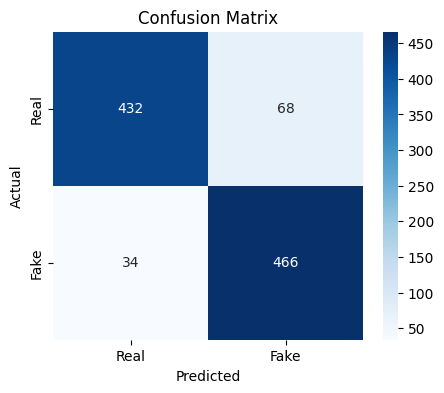

(0.898,
 array([[432,  68],
        [ 34, 466]]))

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.cuda()
            labels = labels.numpy()  # convert to CPU numpy
            outputs = model(imgs)
            probs = torch.sigmoid(outputs).cpu().numpy().flatten()

            preds = (probs > 0.5).astype(int)  # threshold

            all_labels.extend(labels)
            all_preds.extend(preds)

    # Accuracy
    acc = accuracy_score(all_labels, all_preds)
    print("Accuracy:", acc)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Real", "Fake"],
                yticklabels=["Real", "Fake"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return acc, cm

# Run evaluation
evaluate_model(model, val_dl)


In [ ]:
import torch
from tqdm import tqdm

# Training function
def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0

    for imgs, labels in tqdm(dataloader):
        imgs = imgs.cuda()
        labels = labels.cuda().float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

# Validation function
def validate(model, dataloader, criterion):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.cuda()
            labels = labels.cuda().float().unsqueeze(1)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()

    return total_loss / len(dataloader)


In [ ]:
def predict_image(model, img_path):
    model.eval()
    img = Image.open(img_path).convert("RGB")

    # preprocess
    x = preprocess_image_for_inference(img)

    with torch.no_grad():
        score = torch.sigmoid(model(x)).item()

    # Thresholds
    if score > 0.6:
        label = "REAL"
    elif score < 0.4:
        label = "FAKE"
    else:
        label = "FAKE (Low Confidence)"

    print(f"\nPrediction: {label}")
    print(f"Confidence: {score:.4f}\n")

    return label, score


In [ ]:
for epoch in range(2):
    train_loss = train_one_epoch(model, train_dl, criterion, optimizer)
    val_loss = validate(model, val_dl, criterion)
    print(f"Epoch {epoch+1} completed: train={train_loss:.4f}, val={val_loss:.4f}")


  0%|          | 0/250 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[16, 9, 224, 224] to have 3 channels, but got 9 channels instead

In [ ]:
predict_image(model, "/content/kunal.jpg")


RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[1, 9, 224, 224] to have 3 channels, but got 9 channels instead

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import numpy as np
import torch

def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.cuda()
            labels = labels.numpy()

            outputs = torch.sigmoid(model(imgs)).cpu().numpy()
            preds = (outputs > 0.5).astype(int)

            all_preds.extend(preds.flatten())
            all_labels.extend(labels.flatten())

    acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds)

    print("\nAccuracy:", acc)
    print("\nConfusion Matrix:\n", cm)
    print("\nClassification Report:\n", report)

    return acc, cm, report


In [ ]:
evaluate_model(model, val_dl)



Accuracy: 0.901

Confusion Matrix:
 [[443  57]
 [ 42 458]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90       500
           1       0.89      0.92      0.90       500

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



(0.901,
 array([[443,  57],
        [ 42, 458]]),
 '              precision    recall  f1-score   support\n\n           0       0.91      0.89      0.90       500\n           1       0.89      0.92      0.90       500\n\n    accuracy                           0.90      1000\n   macro avg       0.90      0.90      0.90      1000\nweighted avg       0.90      0.90      0.90      1000\n')

In [ ]:
def get_accuracy(model, dataloader):
    correct = 0
    total = 0

    model.eval()
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.cuda()
            labels = labels.cuda()

            outputs = torch.sigmoid(model(imgs))
            preds = (outputs > 0.5).float()

            correct += (preds.squeeze() == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print("Accuracy:", accuracy)
    return accuracy
